# CS 4641 Final Report

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('data/games.csv')
print(df.shape)
# df.head()

(20058, 16)


---

## Preprocessing

**Manual Dimensionality Reduction:** to remove features that definitely won't be helpful for prediction or won't be accessible before a game is over.

In [3]:
df.drop(['id', 'turns', 'victory_status', 'created_at', 'last_move_at', 'white_id', 'black_id'], axis=1, inplace=True)
df.head()

,rated,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply
0,False,white,15+2,1500,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,True,black,5+10,1322,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,True,white,5+10,1496,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,True,white,20+0,1439,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,True,white,30+3,1523,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


Modifying 'opening_name' so only the primary opening strategy is included. 

In [4]:
# If we want just the first part of opening_name
df['opening_name'] = df['opening_name'].str.split(':').str[0]

In [4]:
print("Unique winner values: " + str(df['winner'].unique()))

print("Number of entries that are draw: " + str((df['winner'] == 'draw').sum()))

# If we want it to be binary classification, drop since its a small number
df = df[df['winner'] != 'draw']
print("Unique winner values: " + str(df['winner'].unique()))

Unique winner values: ['white' 'black' 'draw']
Number of entries that are draw: 950
Unique winner values: ['white' 'black']


Adding Features for <= 5 opening moves

In [5]:
# convert df3 to a list, keep only first 10 values
df['opening_moves'] = df['moves'].str.split(' ').str[:10]

# reduce opening_moves to only contain moves in opening strategy, fill remaining values with NaN
def reduce_moves(row):
    if row['opening_ply'] > 10:
        row['opening_ply'] = 10

    if row['opening_ply'] < 10:
        row['opening_moves'] = row['opening_moves'][:row['opening_ply']] + ([np.nan] * (10 - row['opening_ply']))
    return row

df = df.apply(reduce_moves, axis=1)

df['move1_w'] = df['opening_moves'].str[0]
df['move1_b'] = df['opening_moves'].str[1]
df['move2_w'] = df['opening_moves'].str[2]
df['move2_b'] = df['opening_moves'].str[3]
df['move3_w'] = df['opening_moves'].str[4]
df['move3_b'] = df['opening_moves'].str[5]
df['move4_w'] = df['opening_moves'].str[6]
df['move4_b'] = df['opening_moves'].str[7]
df['move5_w'] = df['opening_moves'].str[8]
df['move5_b'] = df['opening_moves'].str[9]

df.drop(['opening_moves'], axis=1, inplace=True)

Adding feature for difference of white/black performance rating

In [6]:
df['perf_comp'] = df['black_rating'] - df['white_rating']

**Feature Encoding:** Encode non-numerical features

In [7]:
# Finding counts of unique values in these columns to see if One-hot encoding is feasible
print("increment_code: " + str(df['increment_code'].nunique()))
print("opening_eco: " + str(df['opening_eco'].nunique()))
print("opening_name: " + str(df['opening_name'].nunique()))
print("moves: " + str(df['moves'].nunique()))

increment_code: 394
opening_eco: 359
opening_name: 1453
moves: 18035


In [8]:
# Use label encoder for opening_name, increment_code, opening_eco, winner
le_opening = preprocessing.LabelEncoder()
df['opening_name'] = le_opening.fit_transform(df['opening_name'])

le_winner = preprocessing.LabelEncoder()
df['winner'] = le_winner.fit_transform(df['winner'])

le_eco = preprocessing.LabelEncoder()
df['opening_eco'] = le_eco.fit_transform(df['opening_eco'])

le_increment = preprocessing.LabelEncoder()
df['increment_code'] = le_increment.fit_transform(df['increment_code'])

le_moves = preprocessing.LabelEncoder()
df['moves'] = le_moves.fit_transform(df['moves'])

le_moves_spec = preprocessing.LabelEncoder()
df['move1_w'] = le_moves_spec.fit_transform(df['move1_w'])
df['move1_b'] = le_moves_spec.fit_transform(df['move1_b'])
df['move2_w'] = le_moves_spec.fit_transform(df['move2_w'])
df['move2_b'] = le_moves_spec.fit_transform(df['move2_b'])
df['move3_w'] = le_moves_spec.fit_transform(df['move3_w'])
df['move3_b'] = le_moves_spec.fit_transform(df['move3_b'])
df['move4_w'] = le_moves_spec.fit_transform(df['move4_w'])
df['move4_b'] = le_moves_spec.fit_transform(df['move4_b'])
df['move5_w'] = le_moves_spec.fit_transform(df['move5_w'])
df['move5_b'] = le_moves_spec.fit_transform(df['move5_b'])

df.head()

,rated,winner,increment_code,white_rating,black_rating,moves,opening_eco,opening_name,opening_ply,move1_w,move1_b,move2_w,move2_b,move3_w,move3_b,move4_w,move4_b,move5_w,move5_b,perf_comp
0,False,1,110,1500,1191,4290,244,1363,5,11,10,25,26,29,64,71,72,72,60,-309
1,True,0,293,1322,1261,1898,70,739,4,11,1,33,35,48,64,71,72,72,60,-61
2,True,1,293,1496,1500,15617,170,642,3,13,12,27,44,48,64,71,72,72,60,4
3,True,1,186,1439,1454,3573,237,976,3,11,10,12,44,48,64,71,72,72,60,15
4,True,1,243,1523,1469,14884,190,771,5,13,12,12,31,31,64,71,72,72,60,-54


Correlation Matrix

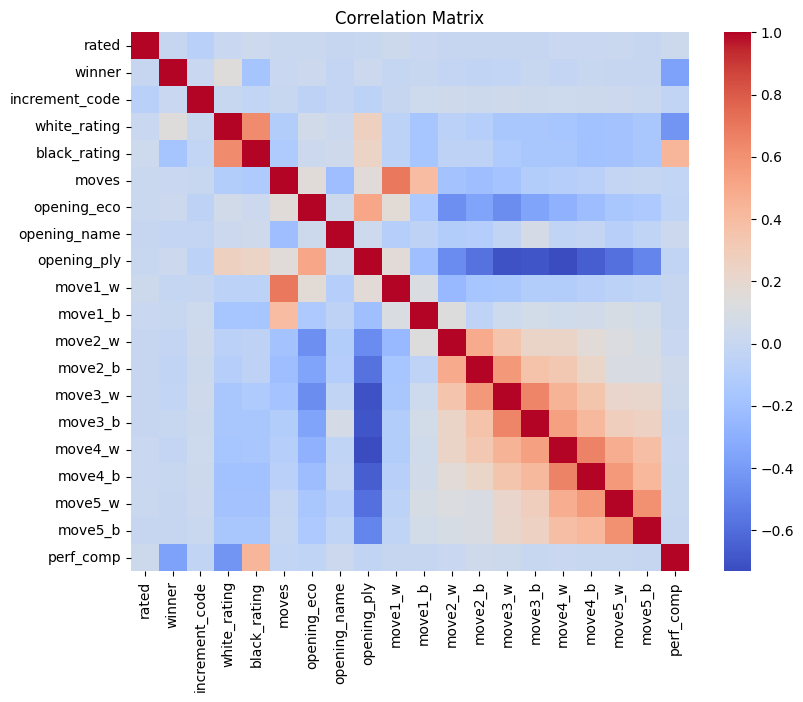

In [9]:
matrix = df.corr()

plt.figure(figsize=(9,7))
plt.title("Correlation Matrix")
sns.heatmap(matrix, cmap="coolwarm", annot=False)
plt.show()

In [11]:
# For now, dropping moves 
df.drop(['moves'], axis=1, inplace=True)

KeyError: "['moves'] not found in axis"

Standardize continuous columns (black_rating, white_rating, perf_comp) for GMM

In [12]:
scaler = StandardScaler()
df_mod = df[['black_rating', 'white_rating', 'perf_comp']]
scaled = scaler.fit_transform(df_mod)

df[['black_rating', 'white_rating', 'perf_comp']] = scaled
df.head()

,rated,winner,increment_code,white_rating,black_rating,opening_eco,opening_name,opening_ply,move1_w,move1_b,move2_w,move2_b,move3_w,move3_b,move4_w,move4_b,move5_w,move5_b,perf_comp
0,False,1,110,-0.323175,-1.362202,244,1363,5,11,10,25,26,29,64,71,72,72,60,-1.202986
1,True,0,293,-0.937091,-1.120939,70,739,4,11,1,33,35,48,64,71,72,72,60,-0.213549
2,True,1,293,-0.336971,-0.297195,170,642,3,13,12,27,44,48,64,71,72,72,60,0.045779
3,True,1,186,-0.533562,-0.455740,237,976,3,11,10,12,44,48,64,71,72,72,60,0.089665
4,True,1,243,-0.243849,-0.404041,190,771,5,13,12,12,31,31,64,71,72,72,60,-0.185622


**Dimensionality Reduction with PCA:**

In [111]:
# Apply PCA to the current dataset. Store PCA-reduced df separately so we can compare how both perform

# Standardize the features except winner for PCA
features = df.drop(['winner'], axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_scaled)

df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])
df_pca['winner'] = df['winner'].values

print(df_pca.head())
print(f'Original shape: {df.shape}, PCA-reduced shape: {df_pca.shape}')

        PC1       PC2       PC3  winner
0 -0.472497 -1.742916  1.627150       1
1 -1.629336  0.029803  0.489053       0
2 -0.647136  0.023796  0.534141       1
3 -0.454866 -0.961080  0.047531       1
4 -0.141231 -0.600649  0.380437       1
Original shape: (19108, 8), PCA-reduced shape: (19108, 4)


In [112]:
# Display the explained variance ratios
explained_variance = pca.explained_variance_ratio_
for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {variance:.2%}")

Principal Component 1: 27.13%
Principal Component 2: 18.33%
Principal Component 3: 15.33%


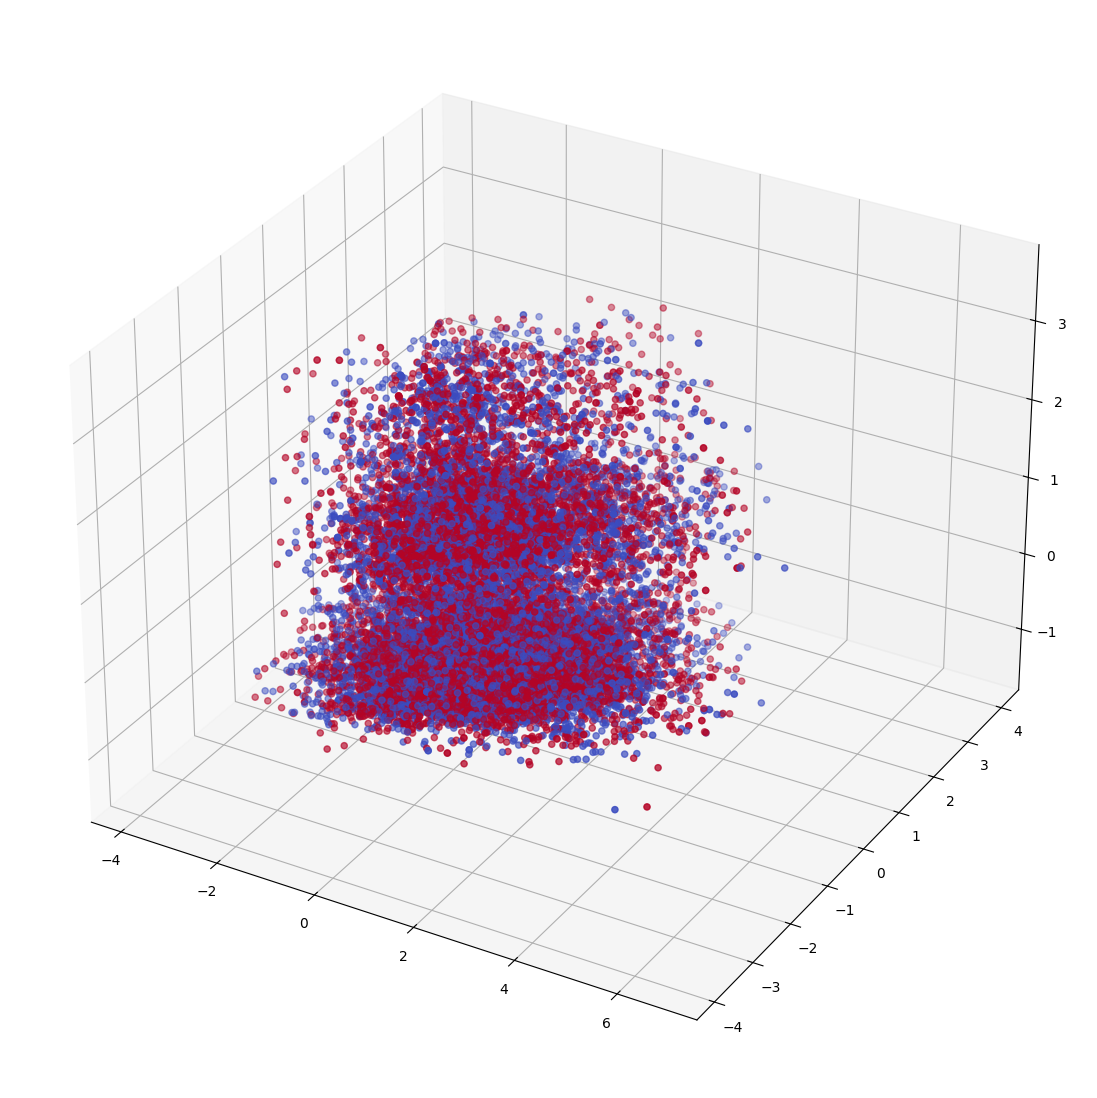

In [148]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(projection='3d')

x = df_pca['PC1']
y = df_pca['PC2']
z = df_pca['PC3']

ax.scatter(x, y, z, c=df_pca['winner'], cmap='coolwarm')
plt.show()

---

## ML Model 1: Random Forest

### Basic Model Fitting to Understand Performance

In [13]:
X = df.drop('winner', axis=1)
y = df['winner']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Cross Validation:** Perform K-Fold cross validation to verify the generalizability of the predictions.

In [15]:
model = RandomForestClassifier()

kfolds = KFold(n_splits=10)
scores = cross_val_score(model, X_train, y_train, cv=kfolds)
print("Accuracies: " + str(scores))
print("Mean Accuracy: " + str(scores.mean()))

Accuracies: [0.65533028 0.65075213 0.64159581 0.64355788 0.65729235 0.64682799
 0.66295812 0.63874346 0.67473822 0.66295812]
Mean Accuracy: 0.6534754347878194


In [16]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

### Fitting Model with PCA-Reduced Dataset

In [118]:
X_pca = df_pca.drop('winner', axis=1)
y_pca = df_pca['winner']

In [119]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

**Cross Validation:** Perform K-Fold cross validation to verify the generalizability of the predictions.

In [120]:
model_pca = RandomForestClassifier()

kfolds_pca = KFold(n_splits=10)
scores_pca = cross_val_score(model_pca, X_train_pca, y_train_pca, cv=kfolds)
print("Accuracies: " + str(scores_pca))
print("Mean Accuracy: " + str(scores_pca.mean()))

Accuracies: [0.55461086 0.56638326 0.52975801 0.58011772 0.5794637  0.55330281
 0.55431937 0.57002618 0.58115183 0.56609948]
Mean Accuracy: 0.5635233222275107


In [121]:
clf_pca = RandomForestClassifier()
clf_pca.fit(X_train_pca, y_train_pca)

RandomForestClassifier()

### Fitting Model with Best Hyperparameters

**Grid Search Cross Validation:** Find and use best hyperparameters using Grid Search

In [122]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],    
    'min_samples_leaf': [1, 2]            
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)

In [123]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [124]:
print("Best Hyperparameters: ", grid_search.best_params_)

Best Hyperparameters:  {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [126]:
X_grid = df.drop('winner', axis=1)
y_grid = df['winner']

In [127]:
X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(X, y, test_size=0.2, random_state=42)

**Cross Validation:** Perform K-Fold cross validation to verify the generalizability of the predictions.

In [128]:
model_grid = RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=200)

kfolds_grid = KFold(n_splits=10)
scores_grid = cross_val_score(model_grid, X_train_grid, y_train_grid, cv=kfolds_grid)
print("Accuracies: " + str(scores_grid))
print("Mean Accuracy: " + str(scores_grid.mean()))

Accuracies: [0.66971877 0.66841073 0.65206017 0.64879006 0.6618705  0.67233486
 0.65772251 0.65314136 0.66688482 0.65575916]
Mean Accuracy: 0.6606692941696144


In [129]:
clf_grid = RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=200)
clf_grid.fit(X_train_grid, y_train_grid)

RandomForestClassifier(max_depth=20, max_features='log2', min_samples_split=5,
                       n_estimators=200)

## Evaluation Metrics:

### Basic Random Forest Evaluation

In [17]:
train_accuracy = clf.score(X_train, y_train)
print("Train Score: " + str(train_accuracy))
test_accuracy = clf.score(X_test, y_test)
print("Test Score: " + str(test_accuracy))

y_pred = clf.predict(X_test)

Train Score: 0.9990841292686118
Test Score: 0.6569858712715856


In [18]:
precision = precision_score(y_test, y_pred)
print("Precision: " + str(precision))
recall = recall_score(y_test, y_pred, average='weighted')
print("Recall: " + str(recall))
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score: " + str(f1))
report = classification_report(y_test, y_pred, target_names=['black', 'white'])
print("\nClassification Report:")
print(report)

Precision: 0.6688214818498259
Recall: 0.6569858712715856
F1 Score: 0.6568974093004815

Classification Report:
              precision    recall  f1-score   support

       black       0.64      0.64      0.64      1832
       white       0.67      0.68      0.67      1990

    accuracy                           0.66      3822
   macro avg       0.66      0.66      0.66      3822
weighted avg       0.66      0.66      0.66      3822



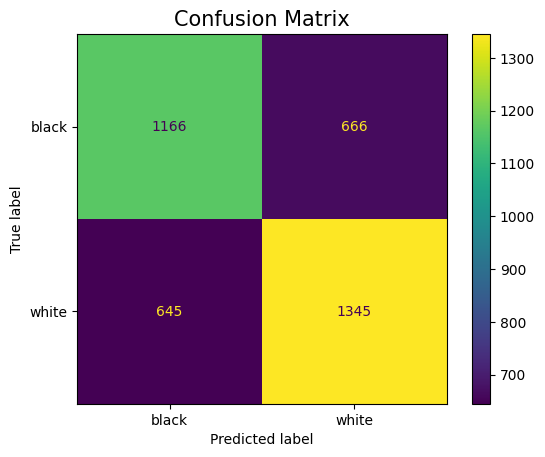

In [19]:
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['black', 'white'])
display.plot()
plt.title('Confusion Matrix', fontsize=15)
plt.show()

### Random Forest (Fit on PCA-Reduced Data) Evaluation

In [133]:
train_accuracy_pca = clf_pca.score(X_train_pca, y_train_pca)
print("Train Score: " + str(train_accuracy_pca))
test_accuracy_pca = clf_pca.score(X_test_pca, y_test_pca)
print("Test Score: " + str(test_accuracy_pca))

y_pred_pca = clf_pca.predict(X_test_pca)

Train Score: 0.9990187099306554
Test Score: 0.5601779173207745


In [134]:
precision_pca = precision_score(y_test_pca, y_pred_pca)
print("Precision: " + str(precision_pca))
recall_pca = recall_score(y_test_pca, y_pred_pca, average='weighted')
print("Recall: " + str(recall_pca))
f1_pca = f1_score(y_test_pca, y_pred_pca, average='weighted')
print("F1 Score: " + str(f1_pca))
report_pca = classification_report(y_test_pca, y_pred_pca, target_names=['black', 'white'])
print("\nClassification Report:")
print(report_pca)

Precision: 0.5737470167064439
Recall: 0.5601779173207745
F1 Score: 0.5593425027813125

Classification Report:
              precision    recall  f1-score   support

       black       0.54      0.51      0.53      1832
       white       0.57      0.60      0.59      1990

    accuracy                           0.56      3822
   macro avg       0.56      0.56      0.56      3822
weighted avg       0.56      0.56      0.56      3822



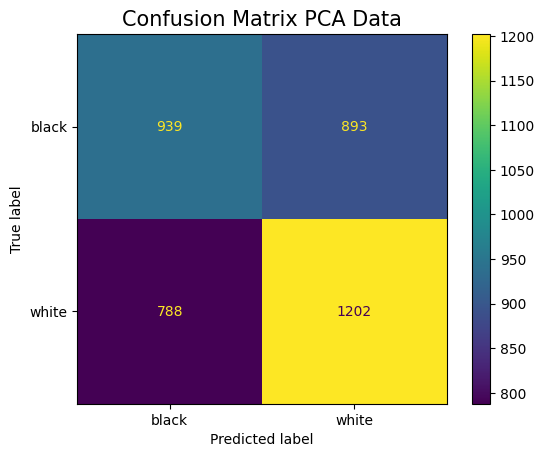

In [135]:
matrix_pca = confusion_matrix(y_test_pca, y_pred_pca)
display_pca = ConfusionMatrixDisplay(confusion_matrix=matrix_pca, display_labels=['black', 'white'])
display_pca.plot()
plt.title('Confusion Matrix PCA Data', fontsize=15)
plt.show()

### Random Forest with Best Hyperparameters Evaluation

In [136]:
train_accuracy_grid = clf_grid.score(X_train_grid, y_train_grid)
print("Train Score: " + str(train_accuracy_grid))
test_accuracy_best = clf_grid.score(X_test_grid, y_test_grid)
print("Test Score: " + str(test_accuracy_best))

y_pred_grid = clf_grid.predict(X_test_grid)

Train Score: 0.9733743294517859
Test Score: 0.6548927263212978


In [137]:
precision_grid = precision_score(y_test_grid, y_pred_grid)
print("Precision: " + str(precision_grid))
recalll_grid = recall_score(y_test_grid, y_pred_grid, average='weighted')
print("Recall: " + str(recall))
f1_grid = f1_score(y_test_grid, y_pred_grid, average='weighted')
print("F1 Score: " + str(f1_grid))
report_grid = classification_report(y_test_grid, y_pred_grid, target_names=['black', 'white'])
print("\nClassification Report: ")
print(report_grid)

Precision: 0.6595339990489777
Recall: 0.6577708006279435
F1 Score: 0.6541656007295581

Classification Report: 
              precision    recall  f1-score   support

       black       0.65      0.61      0.63      1832
       white       0.66      0.70      0.68      1990

    accuracy                           0.65      3822
   macro avg       0.65      0.65      0.65      3822
weighted avg       0.65      0.65      0.65      3822



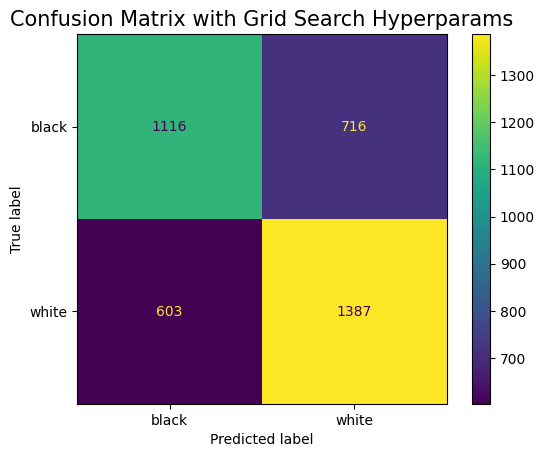

In [138]:
matrix_grid = confusion_matrix(y_test_grid, y_pred_grid)
display_grid = ConfusionMatrixDisplay(confusion_matrix=matrix_grid, display_labels=['black', 'white'])
display_grid.plot()
plt.title('Confusion Matrix with Grid Search Hyperparams', fontsize=15)
plt.show()

### Evaluating Feature Importance

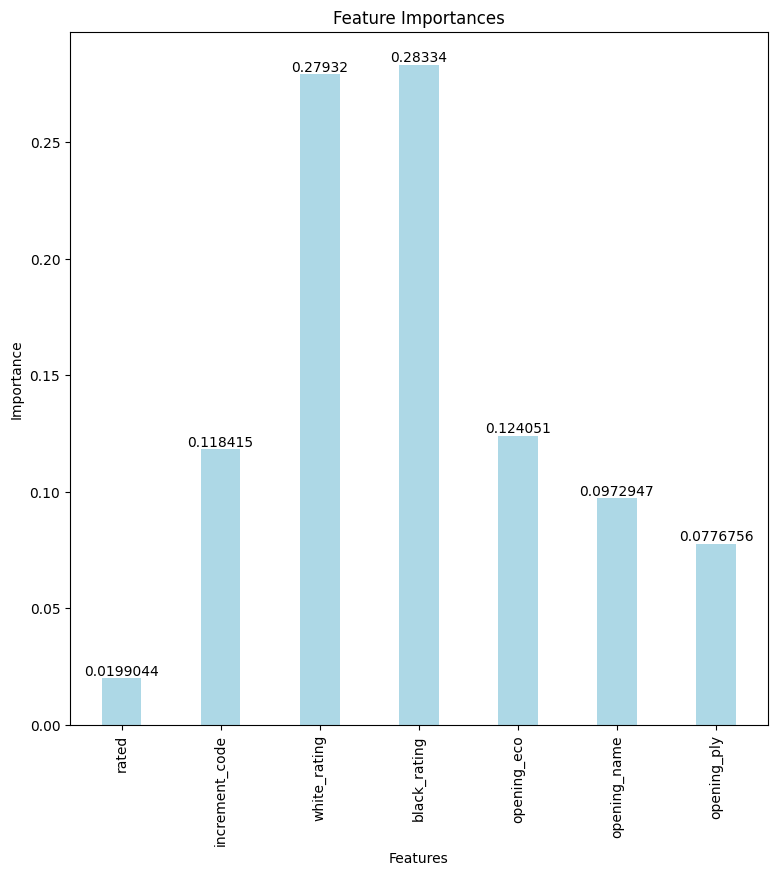

In [147]:
importances = clf.feature_importances_
features = X.columns.to_list()

plt.figure(figsize=(9, 9))
plt.title("Feature Importances")

bar = plt.bar(features, importances, color ='lightblue', width = 0.4)

plt.xlabel("Features")
plt.ylabel("Importance")
plt.bar_label(bar)
plt.xticks(rotation=90)
plt.show()